In [3]:
import os
import ee
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

import geemap

from geeml.utils import eeprint

In [4]:
import ee
service_account = 'github-action@ee-geethensingh.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, r"C:\Users\coach\myfiles\postdoc\Fire\code\secret.json")
ee.Initialize(credentials)

In [7]:
os.chdir(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src")
os.getcwd()

'C:\\Users\\coach\\myfiles\\postdoc\\Fire\\code\\Burn_Area_Mapping\\src'

In [9]:
from components.data_extraction import extractDataset
%load_ext autoreload

ModuleNotFoundError: No module named 'exception'

In [4]:
%autoreload 2

In [6]:
Map = geemap.Map()
fc = ee.FeatureCollection("projects/ee-geethensingh/assets/postdoc/proj_fired_south_africa_to2021182_events")
Map.addLayer(ee.Feature(fc.first()), {'color': 'red'}, "Fire Test")
Map.centerObject(fc.first(), 12)
Map

Map(center=[-31.374999751707104, 29.510986261502627], controls=(WidgetControl(options=['position', 'transparen…

## Step 1: Data extraction

In [7]:
# Filter fire events to period and area of interest
fireEvents = fc.map(lambda ft: ft.set('system:time_start', ee.Date(ft.get('ig_date')))
                    .set('system:time_end', ee.Date(ft.get('last_date')))).filterDate('2019-01-01', '2020-01-01')

In [8]:
# Get Landsat-8 features for South Africa
extractDataset('LANDSAT_8', 'South Africa', ee.Date('2019-09-01'), ee.Date('2020-01-01'), fireEvents, 16, 'extract_20190912.csv')

  0%|          | 0/572 [00:00<?, ?it/s]

## Step 2: train and evaluation

In [7]:
from data_ingestion import dataIngestion
from data_transformation import dataTransformation
from model_trainer import modelTrainer

Naive Baseline Accuracy: 0.74
No best model found, metric < 0.6


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached 'artifacts'
            git commit -m "stop tracking artifacts" 


classification report               precision    recall  f1-score   support

         0.0       0.79      0.93      0.86       206
         1.0       0.59      0.28      0.38        71

    accuracy                           0.77       277
   macro avg       0.69      0.61      0.62       277
weighted avg       0.74      0.77      0.73       277

Confusion Matrix:


0.380952380952381

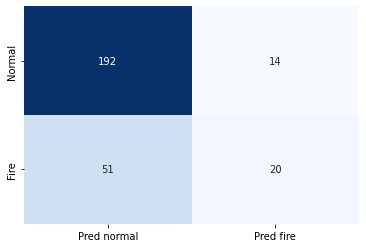

In [8]:
obj = dataIngestion()
train_path, calibration_path, test_path = obj.initiate_data_ingestion()
data_transformation = dataTransformation()
train_arr, cal_arr, test_arr = data_transformation.initiate_data_transformation(train_path, calibration_path, test_path)

model_trainer = modelTrainer()
model_trainer.initiate_model_trainer(train_arr, cal_arr, test_arr)

## Step 3: Inference

In [21]:
from src.utils import load_object
import pandas as pd

from mapie.classification import MapieClassifier

# model = load_object(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\model.pkl")
df = pd.read_csv(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\train.csv")


X_train = df.drop(['scenes', 'label'], axis=1)
y_train = df[['label']]

# from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state= 42, verbose= False).fit(X_train, y_train)
print(model.predict(dfPredict))

mapie_score = MapieClassifier(estimator = model, cv="prefit", method="lac", random_state= 42)
mapie_score.fit(X_train, y_train)
mapie_score.predict(dfPredict, alpha =0.05)

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]


(array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([[[ True],
         [False]],
 
        [[F

In [25]:
from inference import Inference

inference_pipeline = Inference()
sceneList = inference_pipeline.initiate_inference_pipeline('LANDSAT_8', 'South Africa')
sceneList

Number of new scenes: 55
input dates 2024-03-01 2024-04-02


  0%|          | 0/55 [00:00<?, ?it/s]

0    2_LC08_160092_20240310
0    2_LC08_167079_20240311
0    2_LC08_167080_20240311
0    2_LC08_168077_20240302
0    2_LC08_168078_20240302
0    2_LC08_168080_20240302
0    2_LC08_168081_20240302
0    2_LC08_168082_20240302
0    2_LC08_169075_20240309
0    2_LC08_169078_20240309
0    2_LC08_169079_20240309
0    2_LC08_169080_20240309
0    2_LC08_169082_20240309
0    2_LC08_171076_20240307
0    2_LC08_171078_20240307
0    2_LC08_171079_20240307
0    2_LC08_171080_20240307
0    2_LC08_171081_20240307
0    2_LC08_171082_20240307
0    2_LC08_173077_20240305
0    2_LC08_173078_20240305
0    2_LC08_173079_20240305
0    2_LC08_173080_20240305
0    2_LC08_173081_20240305
0    2_LC08_173082_20240305
0    2_LC08_175077_20240303
0    2_LC08_175078_20240303
0    2_LC08_175082_20240303
0    2_LC08_176077_20240310
0    2_LC08_176078_20240310
0    2_LC08_177081_20240301
Name: scenes, dtype: object

In [43]:
# Example usage:
# Delete logs older than March 1, 2024
delete_old_logs(r'C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping', datetime.datetime(2024, 3, 11))
# Or, delete logs older than one month (default behavior)
delete_old_logs(r'C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping')

Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_06_2024_14_13_35.log\03_06_2024_14_13_35.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_06_2024_23_25_28.log\03_06_2024_23_25_28.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_07_2024_09_11_34.log\03_07_2024_09_11_34.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_07_2024_20_08_47.log\03_07_2024_20_08_47.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_08_2024_09_41_30.log\03_08_2024_09_41_30.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_08_2024_10_15_57.log\03_08_2024_10_15_57.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_08_2024_10_19_03.log\03_08_2024_10_19_03.log
Deleted file:

## Stage 2: Semantic Segmentation

In [1]:
import os
os.getcwd()
os.chdir('c:\\Users\\coach\\myfiles\\postdoc\\Fire\\code\\Burn_Area_Mapping\\src')

%load_ext autoreload

In [27]:
%autoreload 2
from stage_2.inference import segment

segment().main()

Consider adjusting `region`, `scale` and/or `dtype` to reduce the LC08_160092_20240310.tif download size (raw: 5.76 GB).


LC08_160092_20240310.tif: |          | 0.00/5.76G (raw) [  0.0%] in 00:00 (eta:     ?)

RasterioIOError: Attempt to create new tiff file 'artifacts\segScenes\LC08_160092_20240310.tif' failed: No such file or directory

In [22]:
# check which scenes need to be downloaded
from src.utils import load_object
import ee
from geeml.utils import eeprint
from geedim.download import BaseImage
import torch
import segmentation_models_pytorch as smp
# ee.Authenticate()
ee.Initialize()


downloadList = load_object(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\downloadList.pkl")
downloadList
# load image
for img in downloadList[20:21]:
    print(img[2:])
    eeImg = ee.Image.load(f'LANDSAT/LC08/C02/T1_TOA/{img[2:]}').select(["B1","B2","B3","B4","B5","B6","B7","B9"])
    # eeprint(eeImg.bandNames())
    # download scenes
    filename = f'C:/Users/coach/myfiles/postdoc/Fire/code/Burn_Area_Mapping/src/components/artifacts/segScenes/{img[2:]}.tif'
    BaseImage(eeImg).download(filename, crs='EPSG:4326', region= eeImg.geometry(), scale=30, overwrite=True, num_threads=20, dtype= 'float64')
    #load model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = smp.Unet(
        encoder_name="resnet34",        
        encoder_weights= None,     
        in_channels=10,                  
        classes=2,  
    ).to(device)
    checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth")
    model.load_state_dict(checkpoint)
    
    # run inference
    #5min13s to download and 1min to run inference
    # upload to gee imagecollection

LC08_173078_20240305


Consider adjusting `region`, `scale` and/or `dtype` to reduce the LC08_173078_20240305.tif download size (raw: 4.26 GB).


LC08_173078_20240305.tif: |          | 0.00/4.26G (raw) [  0.0%] in 00:00 (eta:     ?)

In [20]:
import geemap
Map = geemap.Map()
img = "2_LC08_173078_20240305"
eeimg = ee.Image.load(f'LANDSAT/LC08/C02/T1_TOA/{img[2:]}').select(["B7","B5","B4"])
Map.addLayer(eeimg, {'bands': ['B7', 'B5', 'B4'], 'min':0, 'max':0.7})
Map.centerObject(eeimg.geometry(), 9)
Map

Map(center=[-25.995204899918985, 23.860780416242243], controls=(WidgetControl(options=['position', 'transparen…

0
Window(col_off=0, row_off=0, width=320, height=313)
Window shape: (313, 320), Window location: Window(col_off=0, row_off=0, width=320, height=313)


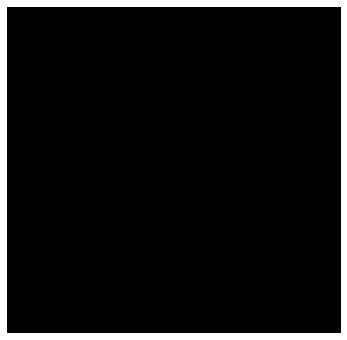

256
Window(col_off=224, row_off=0, width=320, height=313)
Window shape: (313, 320), Window location: Window(col_off=224, row_off=0, width=320, height=313)


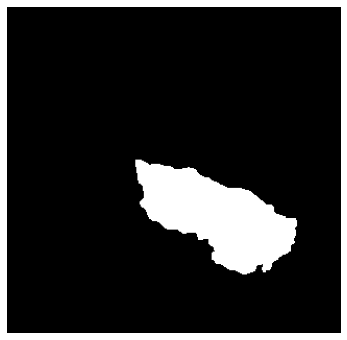

512
Window(col_off=480, row_off=0, width=283, height=313)
Window shape: (313, 283), Window location: Window(col_off=480, row_off=0, width=283, height=313)


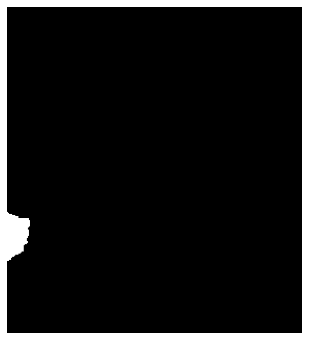

0
Window(col_off=0, row_off=224, width=320, height=89)
Window shape: (89, 320), Window location: Window(col_off=0, row_off=224, width=320, height=89)


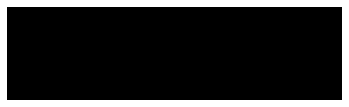

256
Window(col_off=224, row_off=224, width=320, height=89)
Window shape: (89, 320), Window location: Window(col_off=224, row_off=224, width=320, height=89)


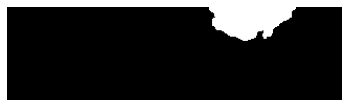

512
Window(col_off=480, row_off=224, width=283, height=89)
Window shape: (89, 283), Window location: Window(col_off=480, row_off=224, width=283, height=89)


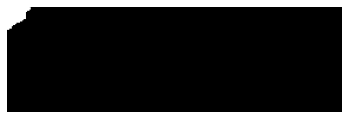

In [29]:
import rasterio as rio
from rasterio import windows
import matplotlib.pyplot as plt

# Define the path to the raster file
raster_path = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\Y\label_0.tif"

def overlapping_blocks(src, overlap=0, band=1, patch_size=64):
    profile = src.profile
    profile.update(blockxsize= patch_size, blockysize= patch_size, tiled=True, count=1)

    for ji, window in src.block_windows(1):
        # Adjust the window to include the overlap
        col_off = max(window.col_off - overlap, 0)
        print(window.col_off)
        row_off = max(window.row_off - overlap, 0)
        width = min(patch_size + overlap * 2, src.width - col_off)
        height = min(patch_size + overlap * 2, src.height - row_off)
        
        window = windows.Window(
            col_off=col_off,
            row_off=row_off,
            width=width,
            height=height
        )
        print(window)
        yield window

# Function to plot the window
def plot_window(data):
    plt.figure(figsize=(6, 6))
    plt.imshow(data, cmap='gray')
    plt.axis('off')
    plt.show()

def process_image(src_img, band_id=1):
    with rio.open(src_img) as src:
        for window in overlapping_blocks(src, overlap=32, patch_size=256):
            src_data = src.read(band_id, window=window)
            print(f'Window shape: {src_data.shape}, Window location: {window}')
            plot_window(src_data)

process_image(raster_path)


In [12]:
import os
import torch
import rasterio as rio
import math
from pathlib import Path
from torchvision import transforms
from tqdm.auto import tqdm
import concurrent.futures
import threading
import logging
from typing import Callable, Optional, Generator

def overlapping_blocks(src: rio.io.DatasetReader, overlap: int = 0, patch_size: int = 64) -> Generator[rio.windows.Window, None, None]:
    """
    Generator to yield overlapping windows from a raster file.

    Args:
        src (rasterio.io.DatasetReader): The source raster dataset.
        overlap (int): Number of pixels to overlap between adjacent windows.
        patch_size (int): Size of each window (patch).

    Yields:
        Generator[rasterio.windows.Window]: Overlapping windows.
    """
    profile = src.profile
    profile.update(blockxsize=patch_size, blockysize=patch_size, tiled=True, count=1)

    for ji, window in dst.block_windows(1):
        # Adjust the window to include the overlap
        col_off = max(window.col_off - overlap, 0)
        row_off = max(window.row_off - overlap, 0)
        width = min(patch_size + overlap * 2, src.width - col_off)
        height = min(patch_size + overlap * 2, src.height - row_off)
        
        window = rio.windows.Window(
            col_off=col_off,
            row_off=row_off,
            width=width,
            height=height
        )
        yield window

def inference(infile: str, imgTransforms: Callable, model: torch.nn.Module, outfile: str, patchSize: int, overlap: int = 0, num_workers: int = 4, device: Optional[str] = None) -> None:
    """
    Run inference using a model on an input file block-by-block and write to a new file (outfile).
    In the case that the input image width/height is not exactly divisible by 32, padding
    is added for inference and removed prior to saving the outfile.

    Args:
        infile (str): Path to input image/covariates.
        imgTransforms (Callable): Transformations to apply to the input image.
        model (torch.nn.Module): Loaded trained model/checkpoint.
        outfile (str): Path to save predicted image.
        patchSize (int): Size of each patch for processing. Must be a multiple of 32.
        overlap (int): Number of pixels to overlap between adjacent windows.
        num_workers (int): Number of workers to parallelize across.
        device (Optional[str]): Device to run the model on ('cpu' or 'cuda').

    Returns:
        None
    """

    with rio.open(infile) as src:
        logger = logging.getLogger(__name__)

        # Create a destination dataset based on source params. The
        # destination will be tiled, and we'll process the tiles
        # concurrently.
        profile = src.profile
        profile.update(blockxsize=patchSize, blockysize=patchSize, tiled=True, count=1)

        with rio.open(Path(outfile), "w", **profile) as dst:
            # Use overlapping_blocks generator to create windows with overlap
            windows = [window for window in overlapping_blocks(src, overlap=overlap, patch_size=patchSize)]

            # Use a lock to protect the DatasetReader/Writer
            read_lock = threading.Lock()
            write_lock = threading.Lock()

            def process(window: rio.windows.Window) -> None:
                """
                Process a single window: read, transform, run inference, and write output.

                Args:
                    window (rasterio.windows.Window): The window to process.

                Returns:
                    None
                """
                with read_lock:
                    # Read the data from the source raster within the window
                    src_array = src.read(window=window)  # nbands, nrows, ncols (4, h, w)
                    w, h = src_array.shape[1], src_array.shape[2]
                    
                    # Apply transformations to the image
                    image = imgTransforms({"image": torch.from_numpy(src_array)})['image']
                    image = image.to(device, dtype=torch.float)  # (1, h, w, 4)
                    
                    # Calculate padding needed to make dimensions multiples of 32
                    hpad = math.ceil(h / 32) * 32 - h
                    wpad = math.ceil(w / 32) * 32 - w
                    transform = transforms.Pad((0, 0, hpad, wpad))
                    
                    # Add padding to image
                    image = transform(image)
                    model.eval()
                    
                    # Run the model inference
                    output = model(image)[:, 1, :, :].squeeze()  # (1,1,h,w)
                    
                    # Remove padding
                    result = output[0:w, 0:h]
                    result = output[overlap:overlap+w, overlap:overlap+h].detach().cpu()

                with write_lock:
                    # Write the result to the destination raster
                    dst.write(result, 1, window=window)

            # Map the process() function over the list of windows.
            with tqdm(total=len(windows), desc=os.path.basename(outfile)) as pbar:
                with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
                    futures = {executor.submit(process, window): window for window in windows}
                    
                    try:
                        for future in concurrent.futures.as_completed(futures):
                            future.result()
                            pbar.update(1)
                                    
                    except Exception as ex:
                        logger.info('Cancelling...')
                        executor.shutdown(wait=False, cancel_futures=True)
                        raise ex        

# Example usage
# Define your transforms, model, and other parameters here
# imgTransforms = ...
# model = ...
# inference(infile='path_to_infile.tif', imgTransforms=imgTransforms, model=model, outfile='path_to_outfile.tif', patchSize=224, overlap=1, num_workers=4, device='cuda')


In [23]:
import os
import ee

# from utils import load_object
# import geedim as gd
import torch
import rasterio as rio
import math
from pathlib import Path
# from src.utils import normalise_input, denormalise_output
from torchvision import transforms
from typing import Callable, Optional, Generator


# Parallel compute
from tqdm.auto import tqdm
import concurrent.futures
import threading
import logging

from itertools import product

def overlapping_blocks(src: rio.io.DatasetReader, patch_size: int = 64, overlap: int = 0, ) -> Generator[rio.windows.Window, None, None]:
    """
    Generator to yield overlapping windows from a raster file.

    Args:
        src (rasterio.io.DatasetReader): The source raster dataset.
        overlap (int): Number of pixels to overlap between adjacent windows.
        patch_size (int): Size of each window (patch).

    Yields:
        Generator[rasterio.windows.Window]: Overlapping windows.
    """
    profile = src.profile
    profile.update(blockxsize=patch_size, blockysize=patch_size, tiled=True, count=1)
# 0:320> 32:288
# 256:576> 288:288+256=544
# 512:832> 544: 800
# 768:1088> 800:1056
    for ji, window in src.block_windows(1):
        # Adjust the window to include the overlap[0, 256, 512, 768]
        col_off = window.col_off
        row_off = window.row_off
        width = min(patch_size + overlap*2, src.width - col_off)
        height = min(patch_size + overlap*2, src.height - row_off)
        
        window = rio.windows.Window(
            col_off = col_off,
            row_off = row_off,
            width=width,
            height=height
        )
        yield window
        
def inference(infile, imgTransforms, model, outfile, patchSize, overlap = 0, num_workers=4, device:str = None):
    """
    Run inference using model on infile block-by-block and write to a new file (outfile). 
    In the case, that the infile image width/height is not exactly divisible by 32, padding
    is added for inference and removed prior to the outfile being saved.
    
    Args:
        infile (string): Path to input image/covariates
        model (pth file): Loaded trained model/checkpoint
        outfile (string): Path to save predicted image
        patchSize (int): Must be a multiple of 32. Size independent of model input size.
        num_workers (int): Num of workers to parralelise across
        
    Returns:
        A tif saved to the outfile destination
        
    """

    with rio.open(infile) as src:
        
        logger = logging.getLogger(__name__)

        # Create a destination dataset based on source params. The
        # destination will be tiled, and we'll process the tiles
        # concurrently.
        profile = src.meta
        profile.update(blockxsize= patchSize, blockysize= patchSize, tiled=True, count=1)

        with rio.open(Path(outfile), "w", **profile) as dst:
            windows = [window for window in overlapping_blocks(src, patchSize, overlap)]

            # use a lock to protect the DatasetReader/Writer
            read_lock = threading.Lock()
            write_lock = threading.Lock()

            def process(window):
                with read_lock:
                    src_array = src.read(window=window)#nbands, nrows, ncols(4, h, w)
                    w, h = src_array.shape[1], src_array.shape[2]
                    image = imgTransforms({"image": torch.from_numpy(src_array)})['image']
                    image = image.to(device, dtype=torch.float)#(1, h, w, 4)
                    
                    model.eval()
                    # if edge patch, pad
                    if window.width % 32 != 0 or window.height % 32 != 0:
                        hpad = math.ceil(h/32)*32-h
                        wpad = math.ceil(w/32)*32-w
                        transform = transforms.Pad((0, 0, hpad, wpad))
                        # add padding to image
                        image = transform(image)
                        output = model(image)[:, 1, :, :].squeeze()#(1,1,h,w)
                        # remove padding
                        result = output[0:w, 0:h]
                        result = result[overlap:overlap+w, overlap:overlap+h].detach().cpu()

                    else:
                        result = model(image)[:, 1, :, :].squeeze()#(1,1,h,w)
                        result = result[overlap:overlap+w, overlap:overlap+h].detach().cpu()

                with write_lock:
                    # Adjust the window to exclude the overlap[32, 288, 544, 800]
                    col_off = overlap if window.col_off==0 else window.col_off+overlap
                    row_off = overlap if window.row_off==0 else window.row_off+overlap
                    width = min(patchSize, src.width - col_off)
                    height = min(patchSize, src.height - row_off)
                    
                    window = rio.windows.Window(
                        col_off=col_off,
                        row_off=row_off,
                        width=width,
                        height=height
                    )
                    dst.write(result, 1, window=window)

            # We map the process() function over the list of
            # windows.
            with tqdm(total=len(windows), desc = os.path.basename(outfile)) as pbar:
                with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
                    futures = {executor.submit(process, window): window for window in windows}
                    
                    try:
                        for future in concurrent.futures.as_completed(futures):
                            future.result()
                            pbar.update(1)
                                    
                    except Exception as ex:
                        logger.info('Cancelling...')
                        executor.shutdown(wait=False, cancel_futures=True)
                        raise ex        

In [24]:
import os
os.chdir('c:\\Users\\coach\\myfiles\\postdoc\\Fire\\code\\Burn_Area_Mapping\\src')
os.getcwd()


'c:\\Users\\coach\\myfiles\\postdoc\\Fire\\code\\Burn_Area_Mapping\\src'

In [25]:
from src.utils import load_object
from utils import MyNormalize
from torchgeo.transforms import indices, AugmentationSequential

mean, std = load_object(r"components\artifacts\norm_vals.pkl")
normalize = MyNormalize(mean=mean, stdev=std)

# Create transforms
data_transform = AugmentationSequential(
    indices.AppendNDWI(index_green=2, index_nir=4),
    indices.AppendNDVI(index_nir=4, index_red=3),
    normalize,
    data_keys = ["image"]
)

In [26]:
dd = r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segScenes\predictions\pred1.tif"
inference(infile = filename, imgTransforms= data_transform, model = model, outfile = dd, patchSize = 256, overlap = 64, num_workers=1, device = device)

pred1.tif:   0%|          | 0/1054 [00:00<?, ?it/s]